See my notebook [here](https://colab.research.google.com/drive/1MY6pk3vY7rrYal8oS6_s7zTkGN9lkHQr?usp=sharing) demonstrating how to use my code to train a NeRF model on the `tiny_nerf_data.npz` file used by the original NeRF authors in their notebook [here](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim

# ResNet18
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # self.fc = nn.Linear(2048*4, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                # if isinstance(m, Bottleneck):
                #     nn.init.constant_(m.bn3.weight, 0)
                # elif isinstance(m, BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


# camera-view行列と結合
# MLPに通す
# 得られた視点ごとの特徴量を平均化
# MLPに通してL2正則化→s_tが得られる


# ここまでResNet18

def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def render_radiance_volume(img, target_pose, r_ts, ds, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(img, target_pose, r_ts_batch, ds_batch) # ここで実行してる？
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    w_is = T_is * alpha_is

    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return C_rs


def run_one_iter_of_tiny_nerf(img, target_pose, ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    C_rs_c = render_radiance_volume(img, target_pose, r_ts_c, ds, chunk_size, F_c, t_is_c) # ここで実行してる？
    return C_rs_c


class VeryTinyNeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 6
        self.L_dir = 4
        num_classes = 256
        cat_cam_mat_feats = num_classes + 16
        pos_enc_feats = 3 + 3 * 2 * self.L_pos + num_classes + 16
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        net_width = 256
        self.resnet18 = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes) # 出力は256次元
        
        self.cat_cam_mat_mlp = nn.Sequential(
            nn.Linear(cat_cam_mat_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
        )
        self.vt_to_st = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
        )
        self.early_mlp = nn.Sequential(
            nn.Linear(net_width + self.L_pos*2*3+3, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width + 1), # なんで+1？
            nn.ReLU(),
        )
        self.late_mlp = nn.Sequential(
            nn.Linear(net_width + dir_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, 3),
            nn.Sigmoid(),
        )

    def forward(self, images, poses, xs, ds):
        vt = []
        # print(xs.shape)
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)
        # print(ds.shape)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)
        
        for i,img in enumerate(images):
            outputs_resnet = self.resnet18(img.unsqueeze(0))
            cat_cam_mat = torch.cat((outputs_resnet, torch.flatten(poses[i])), dim=-1)
            outputs_cat_cam_mat = self.cat_cam_mat_mlp(cat_cam_mat) # これをすべての視点から集めたい
            vt.append(outputs_cat_cam_mat)
        # print(vt)
        
        vt = torch.stack([vt], dim=0)
        vt_avg = torch.mean(vt, dim=0) # dim合ってる？
        st = self.vt_to_st(vt_avg)

        # print(outputs_cat_cam_mat.shape)
        xs_encoded = torch.cat((xs_encoded, st.unsqueeze(0).repeat(xs_encoded.shape[0], 1)), dim=-1) # xs_encodedがどんな形してるか？
        outputs = self.early_mlp(xs_encoded)
        sigma_is = outputs[:, 0]
        c_is = self.late_mlp(torch.cat([outputs[:, 1:], ds_encoded], dim=-1))
        return {"c_is": c_is, "sigma_is": sigma_is}

In [74]:
data_f = "test (1).npz"
data = np.load(data_f)
len(data['images'][0])

800

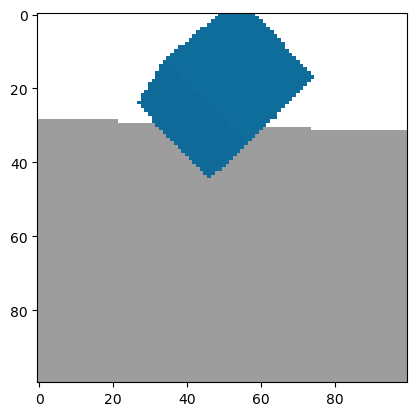

VeryTinyNeRFMLP(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [111]:
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_c = VeryTinyNeRFMLP().to(device)
chunk_size = 16384

lr = 5e-3
optimizer = optim.Adam(F_c.parameters(), lr=lr)
criterion = nn.MSELoss()

data_f = "test (1).npz"
data = np.load(data_f)

images = data["images"][0] / 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, float(data["cam_dist"])])).to(device)

test_idx = 30
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = torch.Tensor(data["poses"].reshape((-1,4,4))).to(device)
test_pose = torch.Tensor(poses[test_idx]).to(device)
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

t_n = 1.0
t_f = 4.0
N_c = 32
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

train_idxs = np.arange(len(images)) != test_idx # test_idxだけ除去(1枚)
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
psnrs = []
iternums = []
num_iters = 20000
display_every = 100
F_c.train()

In [112]:
for i in range(num_iters):
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    C_rs_c = run_one_iter_of_tiny_nerf(
        images[target_img_idx].unsqueeze(0).permute(0,3,1,2).to(device), poses, ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c
    )
    loss = criterion(C_rs_c, images.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % display_every == 0:
        F_c.eval()
        with torch.no_grad():
            C_rs_c = run_one_iter_of_tiny_nerf(
                test_img.unsqueeze(0).permute(0,3,1,2).to(device), test_pose, test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c
            )

        loss = criterion(C_rs_c, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_c.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()

print("Done!")

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
images[0].unsqueeze(0).shape

torch.Size([1, 100, 100, 3])

In [ ]:
print(xs_encoded.shape)

NameError: ignored